In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import nltk

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/conll2000/test.txt
/kaggle/input/conll2000/train.txt


In [2]:
%%time
#Load train and test dataset
def load_data(file):
    '''
    Input:
    file: path to file
    Returns:
    sents: a list of sentences which consist of ((word, pos), chunk)
    '''
    # Opening file 
    f = open(file,'r')
    sents = []
    sent = []
    for line in f:
        cur_line = line.strip()
        if not cur_line:
            sents.append(sent)
            sent = []
        else:
            cur_line = cur_line.split(" ")
            cur_line[2] = cur_line[2][0]
            sent.append(((cur_line[0], cur_line[1]), cur_line[2][0]))
    return sents

#Load train and test dataset
train_file = "/kaggle/input/conll2000/train.txt"
test_file  = "/kaggle/input/conll2000/test.txt"

train_sents = load_data(train_file)
test_sents  = load_data(test_file)
print(train_sents[0])

[(('Confidence', 'NN'), 'B'), (('in', 'IN'), 'B'), (('the', 'DT'), 'B'), (('pound', 'NN'), 'I'), (('is', 'VBZ'), 'B'), (('widely', 'RB'), 'I'), (('expected', 'VBN'), 'I'), (('to', 'TO'), 'I'), (('take', 'VB'), 'I'), (('another', 'DT'), 'B'), (('sharp', 'JJ'), 'I'), (('dive', 'NN'), 'I'), (('if', 'IN'), 'B'), (('trade', 'NN'), 'B'), (('figures', 'NNS'), 'I'), (('for', 'IN'), 'B'), (('September', 'NNP'), 'B'), ((',', ','), 'O'), (('due', 'JJ'), 'B'), (('for', 'IN'), 'B'), (('release', 'NN'), 'B'), (('tomorrow', 'NN'), 'B'), ((',', ','), 'O'), (('fail', 'VB'), 'B'), (('to', 'TO'), 'I'), (('show', 'VB'), 'I'), (('a', 'DT'), 'B'), (('substantial', 'JJ'), 'I'), (('improvement', 'NN'), 'I'), (('from', 'IN'), 'B'), (('July', 'NNP'), 'B'), (('and', 'CC'), 'I'), (('August', 'NNP'), 'I'), (("'s", 'POS'), 'B'), (('near-record', 'JJ'), 'I'), (('deficits', 'NNS'), 'I'), (('.', '.'), 'O')]
CPU times: user 390 ms, sys: 59.1 ms, total: 449 ms
Wall time: 453 ms


In [3]:
#Build Feature Set
def word2features(sent, i, history):
    '''
        Inputs:
        sent: sentence a list of tuples(word, POS)
        i: index into the sentence
        history: previous chunk tags in case of Sentence begin it is BOS
        Returns:
        A feature dictionary consisting of tuples(label, value)
    '''
    
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word[:3]': word.lower()[:3],
        'word[:2]': word.lower()[:2],
        'word[-3:]': word.lower()[-3:],
        'word[-2:]': word.lower()[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'postag': postag,
    }
    
    features['-1:chunk_tag'] = history
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word[-3:]': word1.lower()[-3:],
            '-1:word[-2:]': word1.lower()[-2:],
            '-1:word[:2]': word1.lower()[:2],
            '-1:word[:3]': word1.lower()[:3],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True
 
    if i > 1:
        features['-2:postag'] = sent[i-2][1]
    
    if i > 2:
        features['-3:postag'] = sent[i-3][1]
    
    #Features for words ahead
    if i < len(sent) - 1:
        features['+1:postag'] = sent[i+1][1]
    else:
        features["EOS"] = True
    
    if i < len(sent) - 2:
        features['+2:postag'] = sent[i+2][1]
        
    return features

In [4]:
%%time
##Generate training data
train_set = []
for tagged_sent in train_sents:
    untagged_sent = nltk.tag.untag(tagged_sent)
    history = "BOS"
    for i, (word, chunk) in enumerate(tagged_sent):
        featureset = word2features(untagged_sent, i, history)
        train_set.append((featureset, chunk))
        history = chunk

CPU times: user 1.74 s, sys: 188 ms, total: 1.93 s
Wall time: 1.93 s


In [5]:
%%time
classifier = nltk.MaxentClassifier.train(train_set, algorithm='IIS', trace=100, max_iter = 8)
classifier.show_most_informative_features(n=10)

  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.51830        0.836
             3          -0.36035        0.917
             4          -0.28473        0.922
             5          -0.24255        0.924
             6          -0.21610        0.925
             7          -0.19807        0.927
         Final          -0.18500        0.928
  -3.391 word[:2]=='of' and label is 'O'
  -3.085 EOS==True and label is 'B'
  -2.845 word[:2]=='in' and label is 'O'
  -2.764 word[:2]=='sa' and label is 'O'
  -2.719 -1:word[-3:]=='for' and label is 'I'
  -2.618 postag=='PRP' and label is 'O'
  -2.506 postag=='PRP' and label is 'I'
  -2.437 postag=='NNS' and label is 'O'
  -2.394 word[-3:]=='for' and label is 'I'
  -2.352 word[:2]=='he' and label is 'O'
CPU times: user 22min 35s, sys: 2.47 s, total: 22min 38s
Wall time: 22min 38s


In [6]:
def mylog(x):
    '''
        logarithm function with log(0) = -1e10
    '''
    if x == 0:
        return -1e5
    else:
        return np.log10(x)
    
#Implements Viterbi Algorithm
#Returns tag sequence
tags = ['B', 'I', 'O']
def viterbi(classifier, sent):
    '''
        classifier: MAXENT Classifier
        sent: input sentence
        returns predicted tags
    '''

    len_sent = len(sent)
    len_tagset = len(tags)

    #SEQSCORE and BACKPTR arrays
    SEQSCORE = [[-1e15 for i in range(len_sent)] for j in range(len_tagset)]
    BACKPTR =  [[0 for i in range(len_sent)] for j in range(len_tagset)]

#     null_tag = self.tags_to_num["^"]
#     initialise the null tag
#     SEQSCORE[null_tag][0] = 0
    
    #For first word
    transitions = classifier.prob_classify(word2features(sent, 0, "BOS")) 
    for ctag in range(0, len_tagset):
        SEQSCORE[ctag][0] = mylog(float(transitions.prob(tags[ctag])))
    
    #For remaining words
    for i in range(0, len_sent-1):#Corresponds to a previous word sent[i]
        for ptag in range(0, len_tagset):
            
            transitions = classifier.prob_classify(word2features(sent, i+1, tags[ptag]))
            
            for ctag in range(0, len_tagset):
                prob_p_c = SEQSCORE[ptag][i] + mylog(float(transitions.prob(tags[ctag])))
                if prob_p_c > SEQSCORE[ctag][i+1]:
                    SEQSCORE[ctag][i+1] = prob_p_c
                    BACKPTR[ctag][i+1] = ptag

    #Sequence identification step
    CT = 0
    optimal_prob = -1e15
    for i in range(0, len_tagset):
        if SEQSCORE[i][len_sent-1]>optimal_prob:
            optimal_prob = SEQSCORE[i][len_sent-1]
            CT = i

    pred_tags = [CT for i in range(len_sent)]
    for idx in reversed(range(len_sent-1)):
        pred_tags[idx] = BACKPTR[pred_tags[idx+1]][idx+1]

    pred_tags = [tags[idx] for idx in pred_tags]
    return pred_tags

              precision    recall  f1-score   support

           B       0.94      0.93      0.93     23852
           I       0.90      0.90      0.90     17345
           O       0.94      0.96      0.95      6180

    accuracy                           0.92     47377
   macro avg       0.92      0.93      0.93     47377
weighted avg       0.92      0.92      0.92     47377

CPU times: user 24.7 s, sys: 7 ms, total: 24.7 s
Wall time: 24.7 s


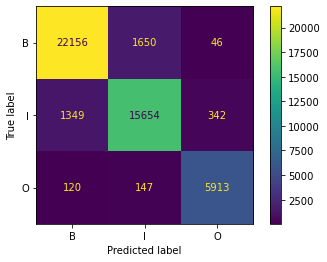

In [7]:
%%time
#Using sklearn.metrics.classification_report
#confusion matrix
from sklearn.metrics import classification_report
tag_to_num = {'B':0, 'I':1, 'O':2}
CONFUSION_MATRIX = [[0 for i in range(len(tags))] for j in range(len(tags))]
y_pred = []
y_true = []
#Classify input sentences
for tagged_sent in test_sents:
    untagged_sent  = nltk.tag.untag(tagged_sent)
    tagged_predict = viterbi(classifier, untagged_sent)
    for i in range(len(untagged_sent)):
        y_pred.append(tagged_predict[i])
        y_true.append(tagged_sent[i][1])
        CONFUSION_MATRIX[tag_to_num[tagged_sent[i][1]]][tag_to_num[tagged_predict[i]]] += 1
print(classification_report(y_true, y_pred))
CONFUSION_MATRIX = np.array(CONFUSION_MATRIX)
from sklearn.metrics import ConfusionMatrixDisplay
conf_display = ConfusionMatrixDisplay(confusion_matrix = CONFUSION_MATRIX, display_labels = tags)
conf_display.plot()

In [8]:
#Build Feature Set without POS
def word2features1(sent, i, history):
    '''
        Inputs:
        sent: sentence a list of tuples(word, POS)
        i: index into the sentence
        history: previous chunk tags in case of Sentence begin it is BOS
        Returns:
        A feature dictionary consisting of tuples(label, value)
    '''
    
    word = sent[i][0]
    
    features = {
        'bias': 1.0,
        'word[:3]': word.lower()[:3],
        'word[:2]': word.lower()[:2],
        'word[-3:]': word.lower()[-3:],
        'word[-2:]': word.lower()[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
    }
    
    features['-1:chunk_tag'] = history
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word[-3:]': word1.lower()[-3:],
            '-1:word[-2:]': word1.lower()[-2:],
            '-1:word[:2]': word1.lower()[:2],
            '-1:word[:3]': word1.lower()[:3],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
    
    if i >= len(sent) - 1:
        features["EOS"] = True
    return features

In [9]:
##Generate training data
train_set1 = []
for tagged_sent in train_sents:
    untagged_sent = nltk.tag.untag(tagged_sent)
    history = "BOS"
    for i, (word, chunk) in enumerate(tagged_sent):
        featureset = word2features1(untagged_sent, i, history)
        train_set1.append((featureset, chunk))
        history = chunk
classifier1 = nltk.MaxentClassifier.train(train_set1, algorithm='IIS', trace=100, max_iter = 8)
classifier1.show_most_informative_features(n=10)

  ==> Training (8 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.51579        0.828
             3          -0.36575        0.901
             4          -0.29589        0.908
             5          -0.25704        0.911
             6          -0.23257        0.913
             7          -0.21580        0.915
         Final          -0.20357        0.916
  -5.137 word[:2]=='of' and label is 'O'
  -4.316 word[:2]=='in' and label is 'O'
  -4.010 word[:2]=='sa' and label is 'O'
  -3.847 EOS==True and label is 'B'
  -3.732 -1:word[-3:]=='for' and label is 'I'
  -3.519 -1:word[-3:]=='hey' and label is 'I'
  -3.499 word[:2]=='he' and label is 'O'
  -3.368 word[-3:]=='for' and label is 'I'
  -3.321 word[:2]=='fr' and label is 'O'
  -3.300 word[-3:]=='uld' and label is 'I'


In [10]:
def mylog(x):
    '''
        logarithm function with log(0) = -1e10
    '''
    if x == 0:
        return -1e5
    else:
        return np.log10(x)
    
#Implements Viterbi Algorithm
#Returns tag sequence
tags = ['B', 'I', 'O']
def viterbi1(classifier, sent):
    '''
        classifier: MAXENT Classifier
        sent: input sentence
        returns predicted tags
    '''

    len_sent = len(sent)
    len_tagset = len(tags)

    #SEQSCORE and BACKPTR arrays
    SEQSCORE = [[-1e15 for i in range(len_sent)] for j in range(len_tagset)]
    BACKPTR =  [[0 for i in range(len_sent)] for j in range(len_tagset)]

#     null_tag = self.tags_to_num["^"]
#     initialise the null tag
#     SEQSCORE[null_tag][0] = 0
    
    #For first word
    transitions = classifier.prob_classify(word2features1(sent, 0, "BOS")) 
    for ctag in range(0, len_tagset):
        SEQSCORE[ctag][0] = mylog(float(transitions.prob(tags[ctag])))
    
    #For remaining words
    for i in range(0, len_sent-1):#Corresponds to a previous word sent[i]
        for ptag in range(0, len_tagset):
            
            transitions = classifier.prob_classify(word2features1(sent, i+1, tags[ptag]))
            
            for ctag in range(0, len_tagset):
                prob_p_c = SEQSCORE[ptag][i] + mylog(float(transitions.prob(tags[ctag])))
                if prob_p_c > SEQSCORE[ctag][i+1]:
                    SEQSCORE[ctag][i+1] = prob_p_c
                    BACKPTR[ctag][i+1] = ptag

    #Sequence identification step
    CT = 0
    optimal_prob = -1e15
    for i in range(0, len_tagset):
        if SEQSCORE[i][len_sent-1]>optimal_prob:
            optimal_prob = SEQSCORE[i][len_sent-1]
            CT = i

    pred_tags = [CT for i in range(len_sent)]
    for idx in reversed(range(len_sent-1)):
        pred_tags[idx] = BACKPTR[pred_tags[idx+1]][idx+1]

    pred_tags = [tags[idx] for idx in pred_tags]
    return pred_tags

              precision    recall  f1-score   support

           B       0.93      0.91      0.92     23852
           I       0.87      0.89      0.88     17345
           O       0.94      0.94      0.94      6180

    accuracy                           0.91     47377
   macro avg       0.91      0.91      0.91     47377
weighted avg       0.91      0.91      0.91     47377

CPU times: user 19 s, sys: 5 ms, total: 19 s
Wall time: 19 s


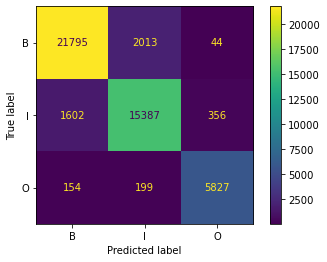

In [11]:
%%time
#Using sklearn.metrics.classification_report
#confusion matrix
from sklearn.metrics import classification_report
tag_to_num = {'B':0, 'I':1, 'O':2}
CONFUSION_MATRIX1 = [[0 for i in range(len(tags))] for j in range(len(tags))]
y_pred = []
y_true = []
#Classify input sentences
for tagged_sent in test_sents:
    untagged_sent  = nltk.tag.untag(tagged_sent)
    tagged_predict = viterbi1(classifier1, untagged_sent)
    for i in range(len(untagged_sent)):
        y_pred.append(tagged_predict[i])
        y_true.append(tagged_sent[i][1])
        CONFUSION_MATRIX1[tag_to_num[tagged_sent[i][1]]][tag_to_num[tagged_predict[i]]] += 1
print(classification_report(y_true, y_pred))
CONFUSION_MATRIX1 = np.array(CONFUSION_MATRIX1)
from sklearn.metrics import ConfusionMatrixDisplay
conf_display = ConfusionMatrixDisplay(confusion_matrix = CONFUSION_MATRIX1, display_labels = tags)
conf_display.plot()